Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime
from datetime import timedelta

from scipy import stats

import requests
from urllib.parse import urlencode

import warnings
warnings.filterwarnings('ignore')

plt.style.use('Solarize_Light2')

%matplotlib inline

In [15]:
# публичные ссылки на файлы Яндекс.Диск
customers_pk = 'https://disk.yandex.ru/d/FUi5uSd6BfG_ig'
orders_pk = 'https://disk.yandex.ru/d/t9Li4JOfgxuUrg'
items_pk = 'https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'

In [16]:
def get_yandex_download_url(public_key):    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [17]:
customers = pd.read_csv(get_yandex_download_url(customers_pk))
orders = pd.read_csv(get_yandex_download_url(orders_pk), parse_dates=[3,4,5,6,7])
items = pd.read_csv(get_yandex_download_url(items_pk))

In [18]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [20]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [21]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


# 1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 
Посмотрим, какие статусы у нас есть вообще

In [22]:
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

По моему мнению, нужно оставить статус только 'delivered', так как товар уже доставлен и принят клиентом. Статусы 'approved', 'created', 'processing', invoiced' вряд ли подойдут, ибо это начальная стадия заказа и она не дает гарантии того, что клиент получит товар или не оформит возврат. Статусы 'unavailable', 'canceled' тоже не подходят, так как клиент точно не получил заказ. 'shipped'близок к правде, но клиент может не прийти за товаром, не открыть дверь, вернуть если что-то не понравится. А вот статус 'delivered' как раз подходит. Есть, конечно, вероятность, что клиент может вернуть товар, но это неизбежно, так как есть вероятность брака и тд.

In [27]:
orders_delivered = orders.query('order_status not in ("canceled", \
                                                      "unavailable", \
                                                      "invoiced", \
                                                      "processing", \
                                                      "created", \
                                                      "approved", \
                                                      "shipped")')
orders_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [28]:
orders_delivered.order_status.value_counts()

delivered    96478
Name: order_status, dtype: int64

Отлично, в датафрейме orders остались только заказы со статусом 'delivered'.

In [31]:
uniq_customers = customers[['customer_unique_id', 'customer_id']]

orders_with_uniq_id = pd.merge(orders_delivered, uniq_customers, how='left')
orders_with_uniq_id = orders_with_uniq_id[['order_id', 'customer_id', 'order_status', 'customer_unique_id']]
orders_with_uniq_id.head()

,order_id,customer_id,order_status,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,72632f0f9dd73dfee390c9b22eb56dd6


Оставим датафрейм таким и посчитаем количество клиентов с одним заказом.

In [35]:
orders_with_uniq_id.groupby('customer_unique_id', as_index=False) \
                   .agg({'order_id': 'count'}) \
                   .query('order_id == 1').shape[0]

90557

Количество клиентов с одним заказом - 90557.

# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)
Если судить логически, то в данном случае статус 'delivered' нам не подходит по причине того, что нужно найти НЕ доставленные заказы.

In [37]:
monthly = orders[orders.order_status != 'delivered']
monthly.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07


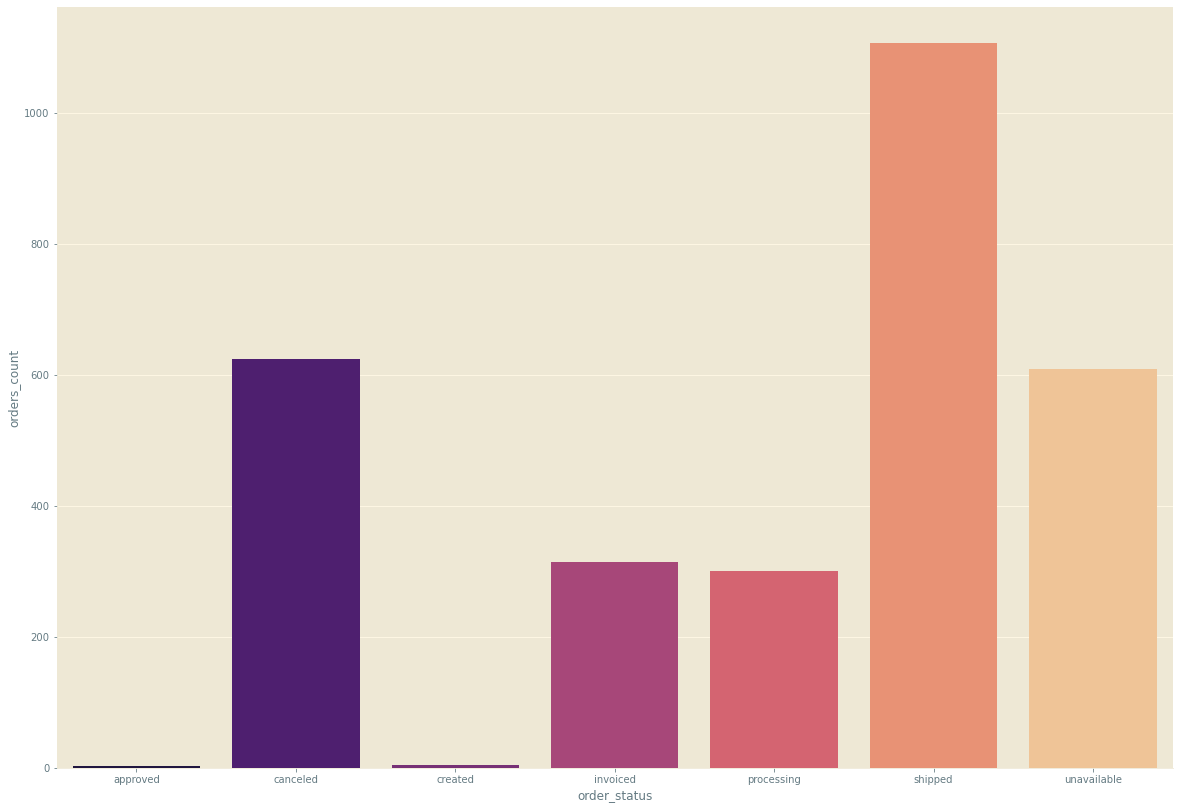

In [130]:
status = monthly.groupby('order_status') \
                .agg({'order_id' : 'count'}) \
                .rename(columns={'order_id' : 'orders_count'}) \
                .reset_index()

fig = plt.figure(figsize=(20,14))

sub1.set_xlabel('Status')
sns.barplot(x=status['order_status'],y=status['orders_count'],data=status,palette='magma')
sns.despine()

In [131]:
status.head(7)

,order_status,orders_count
0,approved,2
1,canceled,625
2,created,5
3,invoiced,314
4,processing,301
5,shipped,1107
6,unavailable,609


Считаю, что корректно будет выделить заказы со статусами 'canceled' и 'unavailable', так как в других статусах нет основания полагать, что они не доставлены или не доставятся.

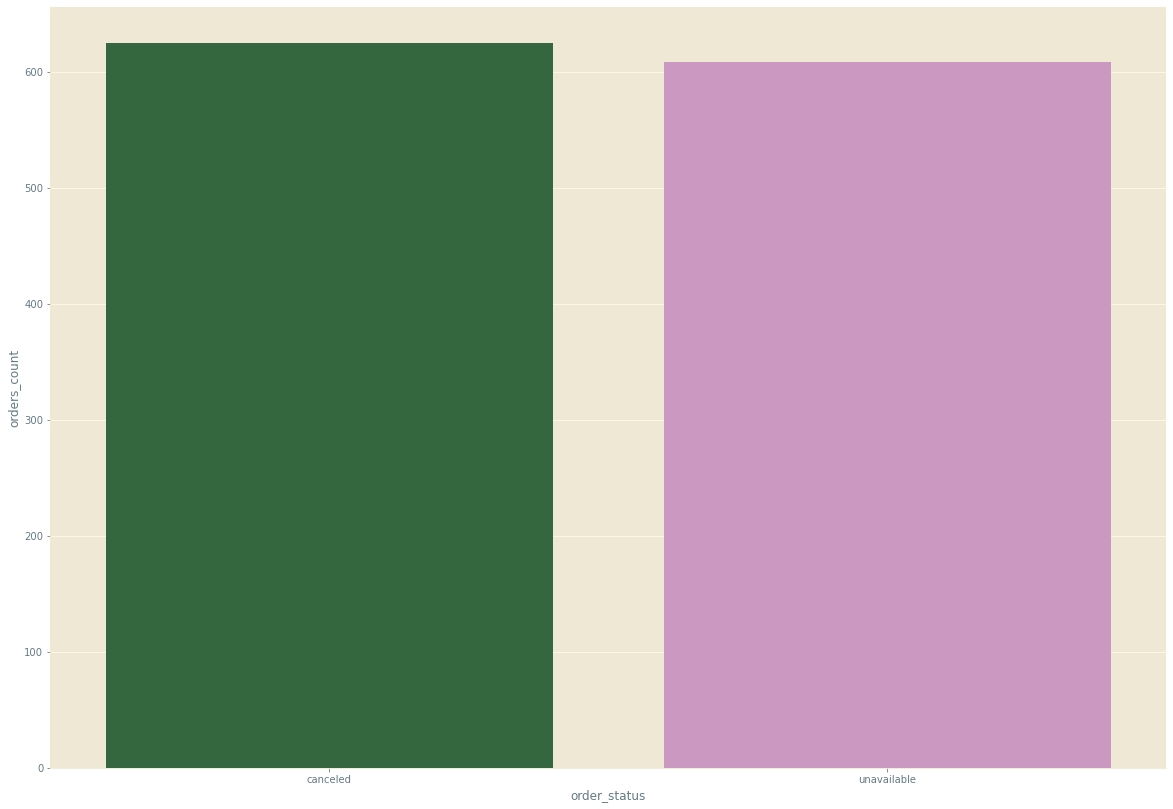

In [132]:
orders_count = monthly.groupby(['order_status']) \
                      .agg({'order_id': 'count'}) \
                      .query("order_status in ('canceled', 'unavailable')") \
                      .rename(columns={'order_id' : 'orders_count'}) \
                      .reset_index()

fig = plt.figure(figsize=(20,14))

sub1.set_xlabel('Status')
sns.barplot(x=orders_count['order_status'],y=orders_count['orders_count'],data=orders_count,palette='cubehelix')
sns.despine()

In [120]:
monthly['estimated_delivery'] = monthly.order_estimated_delivery_date.apply(lambda x: x.strftime('%Y-%m'))

In [122]:
monthly_orders = monthly.groupby(['estimated_delivery', 'order_status']) \
          .agg({'order_id': 'count'}).reset_index()

In [127]:
monthly_orders.query("order_status in ('canceled', 'unavailable')") \
           .groupby('order_status', as_index=False) \
           .agg({'order_id': 'mean'}) \
           .round(1)

,order_status,order_id
0,canceled,24.0
1,unavailable,29.0


# 3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

Здесь нам понадобятся два датафрейма: orders и items.
Соединим их по колонке order_id 

In [134]:
orders_items = pd.merge(orders, items, how='left', on='order_id')
orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [135]:
orders_items['day_of_the_week'] = orders_items['order_purchase_timestamp'].dt.day_name()
orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,day_of_the_week
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday


In [136]:
orders_items.product_id.nunique()

32951

In [138]:
orders_items = orders_items.groupby(['product_id', 'day_of_the_week']) \
                           .agg({'price': 'count'}) \
                           .reset_index()

orders_items.pivot(index='product_id', columns='day_of_the_week', values='price') \
            .idxmax(axis=1) \
            .to_frame() \
            .reset_index() \
            .rename(columns={0:'most_popular_day'})

,product_id,most_popular_day
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,Saturday
32947,fff81cc3158d2725c0655ab9ba0f712c,Monday
32948,fff9553ac224cec9d15d49f5a263411f,Friday
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов)

In [140]:
avg_buys = orders[orders['order_status'].isin(['delivered'])] \
                .merge(customers, how='left', on='customer_id') \
                [['customer_id', 'customer_unique_id', 'order_id', 'order_purchase_timestamp']]
avg_buys.head()

,customer_id,customer_unique_id,order_id,order_purchase_timestamp
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39


In [142]:
avg_buys_orders = avg_buys.groupby(['order_purchase_timestamp', 'customer_unique_id'], as_index=False) \
                          .agg({'order_id': 'count'}) \
                          .rename(columns={'order_id': 'orders_by_month'})
avg_buys_orders.head()

,order_purchase_timestamp,customer_unique_id,orders_by_month
0,2016-09-15 12:16:38,830d5b7aaa3b6f1e9ad63703bec97d23,1
1,2016-10-03 09:44:50,32ea3bdedab835c3aa6cb68ce66565ef,1
2,2016-10-03 16:56:50,2f64e403852e6893ae37485d5fcacdaf,1
3,2016-10-03 21:13:36,61db744d2f835035a5625b59350c6b63,1
4,2016-10-03 22:06:03,8d3a54507421dbd2ce0a1d58046826e0,1


In [144]:
avg_buys_orders['weeks'] = (avg_buys_orders['order_purchase_timestamp'].dt.daysinmonth) / 7
avg_buys_orders.head()

,order_purchase_timestamp,customer_unique_id,orders_by_month,weeks
0,2016-09-15 12:16:38,830d5b7aaa3b6f1e9ad63703bec97d23,1,4.285714
1,2016-10-03 09:44:50,32ea3bdedab835c3aa6cb68ce66565ef,1,4.428571
2,2016-10-03 16:56:50,2f64e403852e6893ae37485d5fcacdaf,1,4.428571
3,2016-10-03 21:13:36,61db744d2f835035a5625b59350c6b63,1,4.428571
4,2016-10-03 22:06:03,8d3a54507421dbd2ce0a1d58046826e0,1,4.428571


In [146]:
avg_buys_orders['orders_by_week'] = avg_buys_orders.orders_by_month / avg_buys_orders.weeks
avg_buys_orders.head()

,order_purchase_timestamp,customer_unique_id,orders_by_month,weeks,orders_by_week
0,2016-09-15 12:16:38,830d5b7aaa3b6f1e9ad63703bec97d23,1,4.285714,0.233333
1,2016-10-03 09:44:50,32ea3bdedab835c3aa6cb68ce66565ef,1,4.428571,0.225806
2,2016-10-03 16:56:50,2f64e403852e6893ae37485d5fcacdaf,1,4.428571,0.225806
3,2016-10-03 21:13:36,61db744d2f835035a5625b59350c6b63,1,4.428571,0.225806
4,2016-10-03 22:06:03,8d3a54507421dbd2ce0a1d58046826e0,1,4.428571,0.225806


In [147]:
buys_week = avg_buys_orders[['customer_unique_id', 'orders_by_week']]
buys_week.head()

,customer_unique_id,orders_by_week
0,830d5b7aaa3b6f1e9ad63703bec97d23,0.233333
1,32ea3bdedab835c3aa6cb68ce66565ef,0.225806
2,2f64e403852e6893ae37485d5fcacdaf,0.225806
3,61db744d2f835035a5625b59350c6b63,0.225806
4,8d3a54507421dbd2ce0a1d58046826e0,0.225806


# 5. Напиши функцию на python, позволяющую строить когортный анализ. В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. (10 баллов)

In [167]:
cohorts = orders.merge(customers, how='left', on='customer_id') \
                 [['customer_unique_id', 'order_purchase_timestamp']]
cohorts['order_month'] = cohorts.order_purchase_timestamp.apply(lambda x: x.strftime('%Y-%m'))
cohorts.head()

,customer_unique_id,order_purchase_timestamp,order_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02


In [168]:
cohorts.set_index('customer_unique_id', inplace=True)
cohorts['join_month'] = cohorts.groupby(level=0)['order_purchase_timestamp'].min().apply(lambda x: x.strftime('%Y-%m'))
cohorts.reset_index(inplace=True)
cohorts.insert(len(cohorts.columns), 'orders_num', 0, allow_duplicates=False)
cohorts.head()

,customer_unique_id,order_purchase_timestamp,order_month,join_month,orders_num
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10,2017-09,0
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07,2018-07,0
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08,2018-08,0
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11,2017-11,0
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02,2018-02,0


In [169]:
# формируем когорты
cohorts_1 = cohorts.groupby(['join_month', 'order_month']) \
                   .agg({'customer_unique_id': pd.Series.nunique, 'orders_num': pd.Series.count}) \
                   .rename(columns={'customer_unique_id': 'total_customers'})
cohorts_1.head()

total_customers  orders_num
join_month order_month                             
2016-09    2016-09                    4           4
2016-10    2016-10                  321         324
           2017-04                    1           1
           2017-07                    1           1
           2017-09                    1           1

In [170]:
def CohortPeriod(C):
    C['cohort_period'] = np.arange(len(C)) + 0
    return C
cohorts_1 = cohorts_1.groupby(level=0).apply(CohortPeriod)
cohorts_1.head()

total_customers  orders_num  cohort_period
join_month order_month                                            
2016-09    2016-09                    4           4              0
2016-10    2016-10                  321         324              0
           2017-04                    1           1              1
           2017-07                    1           1              2
           2017-09                    1           1              3

In [171]:
cohorts_1.reset_index(inplace=True)
cohorts_1.set_index(['cohort_period', 'join_month'], inplace=True)
cohorts_1.head()

order_month  total_customers  orders_num
cohort_period join_month                                         
0             2016-09        2016-09                4           4
              2016-10        2016-10              321         324
1             2016-10        2017-04                1           1
2             2016-10        2017-07                1           1
3             2016-10        2017-09                1           1

In [176]:
cohort_group_size = cohorts_1['total_customers'].groupby(level=1).first()
cohorts_1['total_customers'].unstack(0)

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
join_month,,,,,,,,,,,,,,,,,,
2016-09,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,321.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,764.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0
2017-03,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,4.0,6.0,3.0,4.0,6.0,2.0,4.0
2017-04,2352.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN
2017-05,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,11.0,9.0,12.0,9.0,1.0,7.0,9.0,NaN,NaN
2017-06,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,6.0,NaN,NaN,NaN


In [177]:
retention_rate = cohorts_1['total_customers'].unstack(0).divide(cohort_group_size, axis=0)
retention_rate

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
join_month,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,0.003115,0.003115,0.003115,0.003115,0.003115,0.003115,0.006231,0.006231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.003927,0.002618,0.001309,0.003927,0.001309,0.005236,0.001309,0.001309,0.003927,0.001309,0.007853,0.003927,0.001309,0.001309,0.002618,0.003927,0.001309
2017-02,1.0,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,0.002854,0.001712,0.001712,0.001142,0.000571,0.000571,0.002283
2017-03,1.0,0.004932,0.003794,0.003794,0.003414,0.001517,0.001517,0.003035,0.003414,0.000759,0.003794,0.001517,0.002276,0.001138,0.001517,0.002276,0.000759,0.001517
2017-04,1.0,0.005952,0.002126,0.001701,0.003401,0.002551,0.003401,0.002976,0.002976,0.001701,0.002551,0.000850,0.000850,0.000425,0.000850,0.000850,0.002126,NaN
2017-05,1.0,0.005006,0.005006,0.003893,0.003059,0.003337,0.004171,0.001669,0.002503,0.003059,0.002503,0.003337,0.002503,0.000278,0.001947,0.002503,NaN,NaN
2017-06,1.0,0.004779,0.003504,0.004141,0.002549,0.003823,0.003823,0.002230,0.001274,0.002230,0.003186,0.003504,0.001593,0.001274,0.001911,NaN,NaN,NaN


In [183]:
cohort_analysis = (retention_rate
            .style
            .set_caption('User retention by cohort') 
            .background_gradient(cmap='icefire')
            .highlight_null('white') 
            .format("{:.2%}", na_rep=""))
cohort_analysis

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
join_month,,,,,,,,,,,,,,,,,,
2016-09,100.00%,,,,,,,,,,,,,,,,,
2016-10,100.00%,0.31%,0.31%,0.31%,0.31%,0.31%,0.31%,0.62%,0.62%,,,,,,,,,
2016-12,100.00%,100.00%,,,,,,,,,,,,,,,,
2017-01,100.00%,0.39%,0.26%,0.13%,0.39%,0.13%,0.52%,0.13%,0.13%,0.39%,0.13%,0.79%,0.39%,0.13%,0.13%,0.26%,0.39%,0.13%
2017-02,100.00%,0.23%,0.29%,0.11%,0.40%,0.11%,0.23%,0.17%,0.17%,0.23%,0.11%,0.29%,0.17%,0.17%,0.11%,0.06%,0.06%,0.23%
2017-03,100.00%,0.49%,0.38%,0.38%,0.34%,0.15%,0.15%,0.30%,0.34%,0.08%,0.38%,0.15%,0.23%,0.11%,0.15%,0.23%,0.08%,0.15%
2017-04,100.00%,0.60%,0.21%,0.17%,0.34%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%,0.04%,0.09%,0.09%,0.21%,
2017-05,100.00%,0.50%,0.50%,0.39%,0.31%,0.33%,0.42%,0.17%,0.25%,0.31%,0.25%,0.33%,0.25%,0.03%,0.19%,0.25%,,
2017-06,100.00%,0.48%,0.35%,0.41%,0.25%,0.38%,0.38%,0.22%,0.13%,0.22%,0.32%,0.35%,0.16%,0.13%,0.19%,,,


In [180]:
def C_A(cohorts, customer_unique_id, order_purchase_timestamp):
    cohorts['order_month'] = cohorts.order_purchase_timestamp.apply(lambda x: x.strftime('%Y-%m'))
    
    cohorts.set_index('customer_unique_id', inplace=True)
    cohorts['join_month'] = cohorts.groupby(level=0)['order_purchase_timestamp'].min().apply(lambda x: x.strftime('%Y-%m'))
    cohorts.reset_index(inplace=True)
    cohorts.insert(len(cohorts.columns), 'orders_num', 0, allow_duplicates=False)
    
    cohorts_1 = cohorts_1.groupby(['join_month', 'order_month']) \
                         .agg({'customer_unique_id': pd.Series.nunique, 'orders_num': pd.Series.count}) \
                         .rename(columns={'customer_unique_id': 'total_customers'})
    
    def CohortPeriod(Coh):
        Coh['cohort_period'] = np.arange(len(C)) + 0
        return Coh
    cohorts_1 = cohorts_1.groupby(level=0).apply(CohortPeriod)
    
    cohorts_1.reset_index(inplace=True)
    cohorts_1.set_index(['cohort_period', 'join_month'], inplace=True)
    cohort_group_size = cohorts_1['total_customers'].groupby(level=1).first()
    retention_rate = cohorts_1['total_customers'].unstack(0).divide(cohort_group_size, axis=0)
    
    return retention_rate    